# Installation and importation

In [ ]:
#Installing librabries needed

#!pip install beautifulsoup4
#!pip install requests
#!pip install pandas
#!pip install plotly
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install nbformat
#!pip install Jinja2
#!pip install numpy
#!pip install python-dotenv
#!pip install lxml

In [1]:
#Importing libraries

import datetime
import os
from dotenv import load_dotenv, find_dotenv

import requests
from requests.structures import CaseInsensitiveDict
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import re

import tkinter as tk
from tkinter import ttk

# Usefull functions

In [2]:
#Date of scraping

def today_date():
    date = datetime.date.today()
    current_date = f'{date.day}/{date.month}/{date.year}'
    return current_date

In [3]:
#Deleting last element of a list and putting numbers back together. We have numbers as strings in the dataset, separated by space and with currency at the end

def deleting_last_and_back_together(lst):
    if len(lst) > 0:
        elements = []
        for elem in lst[:-1]:
            elements.append(str(elem))
        return ''.join(elements)
    else:
        return '' 

In [4]:
#Function used to saved the after adding todays (or other website) datas and saving it. We use it to created the database

def dataset_updated (today_df):
    # pd.DataFrame().to_csv('housing_price.csv)   Initialization for the first time 
    df = pd.read_csv('housing_price.csv')
    df_to_save = pd.concat([df,today_df]).reset_index()
    df_to_save.drop(columns=['index'], inplace = True)
    df_to_save.to_csv('housing_price.csv', index = False)

In [5]:
#Function to save the dataset cleaned and ready to be analysed (especially to use with Tableau)

def dataset_cleaned(df__to_cleaned):
    df__to_cleaned.to_csv('housing_price_cleaned.csv', index = False)

In [6]:
#Function used for dataset : I need to look at the lenght of a list in a cell and keeping the ones where lenght is more than 2

def lenth_of_list(mylist):
    if len(mylist) > 2:
        return mylist
    else:
        return '0'

In [7]:
#In order to make sure we scrapp the good district, we need to get the list of them. We will same them into a csv file in case the website change. We will not necesarely need this function again

def neighbourhood_of_warsaw():
    neighb = pd.read_html('https://en.um.warszawa.pl/districts-of-warsaw?p_p_id=com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_mNM61lpdMTMP&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_mNM61lpdMTMP_f_sorting=22433423__22433428__field0__asc')
    neighb = neighb[0]
    neighb = neighb.drop(['Population (census) 20.05.2002 Sort data by column', 'Population (estimate) 31.12.2010 Sort data by column', 'Population (estimate) 31.12.2019 Sort data by column'], axis = 1)


    neighb['Name Sort data by column'] = neighb['Name Sort data by column'].apply(lambda x : re.sub(r"\d+|\W+|\s+", " ", x).strip())
    neighb['Name Sort data by column'] = neighb['Name Sort data by column'].str.split()
    neighb['Name Sort data by column'] = neighb['Name Sort data by column'].apply(lambda x : x[1])
    neighb = neighb.loc[neighb['Name Sort data by column'] != 'Warszawa']
    neighb.to_csv('warsaw_neighbourhood.csv', index = False)
    return neighb


In [8]:
#This function has been used to get the coordinates of Warsaw neighbourhood and save them into a csv file

def neighbourhoods_coordinates(neighbourhoods) :
    location = {}

    load_dotenv()
    API_Key = os.getenv("API_Key")

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    for neighbourhood in neighbourhoods:    
        url = f"https://api.geoapify.com/v1/geocode/search?text={neighbourhood}&format=json&apiKey={API_Key}"
        resp = requests.get(url, headers=headers)

        lon = resp.json()['results'][0]['lon']
        lat = resp.json()['results'][0]['lat']
        
        location[neighbourhood] = {'lon' : lon, 'lat' :lat}

        df_location = pd.DataFrame(location)
        df_location = df_location.T
            
        df_location.to_csv('gps_location_neighbourhood.csv')

In [9]:
def outliers(dataset):

    #Prices Ourtliers
    Q1 = np.percentile(dataset['price'], 25)
    Q3 = np.percentile(dataset['price'], 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    dataset = dataset.loc[(dataset['price'] >= lower_bound) & (dataset['price'] <= upper_bound)].reset_index()
    
    #Size Ourtliers
    Q1 = np.percentile(dataset['size'], 25)
    Q3 = np.percentile(dataset['size'], 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    dataset = dataset.loc[(dataset['size'] >= lower_bound) & (dataset['size'] <= upper_bound)].reset_index()
    
    dataset.drop(columns=['index', 'level_0'], inplace = True)
    return dataset

# Web scrapping

## Scrapping initialization

In [10]:
#Getting the responses from both websites

def scrapping_initialization():
    
    url_domiporta = "https://www.domiporta.pl/mieszkanie/sprzedam/mazowieckie/warszawa?Distance=10"
    response_domiporta = requests.get(url_domiporta)

    url_morizon = "https://www.morizon.pl/mieszkania/warszawa/"
    response_morizon = requests.get(url_morizon)

    print(f'response from domiporta : {response_domiporta}')
    print(f'response from morizon : {response_morizon}')
    
    return response_domiporta, response_morizon

In [11]:
scrapping_init = scrapping_initialization()

response from domiporta : <Response [200]>
response from morizon : <Response [200]>


## Scrapping domiporta website

In [12]:
#Scrapping the fist website. Response as input of the function, and as output we get a cleaned dataset ready to be saved

def scrapping_domiporta(response):
    
    #Scrapping the website:
    soup_domiporta = BeautifulSoup(response.content)
    
    appartment_title_list = []
    appartment_price_list = []
    appartment_size_list = []
    appartment_rooms_list = []
    appartment_neigbourhood_list = []

    components = soup_domiporta.find_all(class_ = 'sneakpeak__data')
    for component in components:
        appartment_title_list.append(component.find(class_ = 'sneakpeak__title--bold').get_text().strip())
        appartment_price_list.append(component.find(class_ = 'sneakpeak__price_value').get_text().strip())
        appartment_size_list.append(component.find(class_ = 'sneakpeak__details_item sneakpeak__details_item--area').get_text().strip())
        appartment_neigbourhood_list.append(component.find(class_ = 'sneakpeak__title--inblock').get_text().strip())
        try :
            appartment_rooms_list.append(component.find(class_ = 'sneakpeak__details_item sneakpeak__details_item--room').get_text().strip())
        except :
            appartment_rooms_list.append('Undefined')
          
    #Creating the dataframe 
    df_domiporta_scraping = pd.DataFrame([appartment_title_list, appartment_price_list, appartment_size_list, appartment_rooms_list, appartment_neigbourhood_list]).T
    df_domiporta_scraping.rename(columns = {0:'housing_type', 1:'price', 2:'size', 3:'rooms', 4:'neighbourhood'}, inplace = True)
    df_domiporta_scraping['website'] = 'Domiporta'
    df_domiporta_scraping['date'] = today_date()

    #Cleaning and preparing housing_type
    df_domiporta_scraping['housing_type'] = df_domiporta_scraping['housing_type'].apply(lambda x : x.split(' ')[0])
    
    #Cleaning and preparing price. We drop the row where we do not have the price. It would be intersting the keep them and see their location or size, but this will not answer our problem
    df_domiporta_scraping = df_domiporta_scraping.loc[df_domiporta_scraping['price'] != 'Zapytaj o cenę'].reset_index()
    df_domiporta_scraping['price'] = df_domiporta_scraping['price'].apply(lambda x : x.replace(u'\xa0', u' ').split(' '))
    df_domiporta_scraping['price'] = df_domiporta_scraping['price'].apply(deleting_last_and_back_together)
    df_domiporta_scraping['price'] = df_domiporta_scraping['price'].apply(lambda x : int(x))

    #Cleaning and preparing size
    df_domiporta_scraping['size'] = df_domiporta_scraping['size'].apply(lambda x : str(x.replace(u'\xa0', u' ')).split(' ')[0])
    df_domiporta_scraping['size'] = df_domiporta_scraping['size'].apply(lambda x : x.replace(',', '.'))
    df_domiporta_scraping['size'] = df_domiporta_scraping['size'].apply(lambda x : float(x))
    
    #Cleaning and preparing rooms
    df_domiporta_scraping['rooms'] = df_domiporta_scraping['rooms'].apply(lambda x : int(x) if x != 'Undefined' else 0)

    #Cleaning and preparing neigbourhood
    df_domiporta_scraping['neighbourhood'] = df_domiporta_scraping['neighbourhood'].apply(lambda x : re.sub(r"\d+|\W+|\s+", " ", x).strip())
    df_domiporta_scraping['neighbourhood'] = df_domiporta_scraping['neighbourhood'].str.split()
    df_domiporta_scraping['neighbourhood'] = df_domiporta_scraping['neighbourhood'].apply(lenth_of_list)
    df_domiporta_scraping = df_domiporta_scraping.loc[df_domiporta_scraping['neighbourhood'] != '0']
    df_domiporta_scraping['neighbourhood'] = df_domiporta_scraping['neighbourhood'].apply(lambda x : x[2])

    #Creating price_per_sq
    df_domiporta_scraping['price_per_sq'] = round(df_domiporta_scraping['price'] / df_domiporta_scraping['size'] , 2)

    #Reordering/deleting columns to make it standar and more readable
    columns_order = ['housing_type', 'price', 'size', 'price_per_sq', 'rooms', 'neighbourhood', 'website', 'date']
    df_domiporta_scraping.drop(columns=['index'], inplace = True)
    df_domiporta_scraping = df_domiporta_scraping[columns_order]
    
    return df_domiporta_scraping

Important note : We only scrap the first page as the intention is the see the price change over day

In [13]:
df_domiporta_scraping = scrapping_domiporta(scrapping_init[0])

In [14]:
df_domiporta_scraping

,housing_type,price,size,price_per_sq,rooms,neighbourhood,website,date
0,mieszkanie,800000,49.98,16006.40,2,Praga,Domiporta,9/11/2023
1,mieszkanie,730000,62.00,11774.19,3,Praga,Domiporta,9/11/2023
2,mieszkanie,819000,83.75,9779.10,4,Rembertów,Domiporta,9/11/2023
3,mieszkanie,678600,39.00,17400.00,2,Mokotów,Domiporta,9/11/2023
4,mieszkanie,799000,52.10,15335.89,2,Ochota,Domiporta,9/11/2023
5,mieszkanie,500000,28.00,17857.14,1,Mokotów,Domiporta,9/11/2023
6,mieszkanie,1397000,104.00,13432.69,6,Ursynów,Domiporta,9/11/2023
7,mieszkanie,1200000,112.58,10659.09,4,Zimna,Domiporta,9/11/2023
8,mieszkanie,545000,21.00,25952.38,1,Wola,Domiporta,9/11/2023
9,mieszkanie,750000,37.00,20270.27,2,Mokotów,Domiporta,9/11/2023


In [15]:
dataset_updated(df_domiporta_scraping)

## Scrapping morizon website

In [16]:
#Scrapping the second website. Response as input of the function, and as output we get a cleaned dataset ready to be saved

def scrapping_morizon(response):
    
    #Scrapping the website:    
    soup_morizon = BeautifulSoup(response.content)
    
    appartment_title_list = []
    appartment_price_list = []
    appartment_size_list = []
    appartment_price_per_sq_list = []
    appartment_rooms_list = []
    appartment_neigbourhood_list = []

    components = soup_morizon.find_all(class_ = 'QABBtF')
    for component in components:
        appartment_title_list.append(component.find(class_ = 'b0Zyng').get_text())
        appartment_price_list.append(component.find(class_ = 'fallNp').get_text())
        appartment_price_per_sq_list.append(component.find(class_ = 'ahEpiL').get_text())
        appartment_size_list.append(component.find(class_ = 'property-info').get_text())
        appartment_rooms_list.append(component.find(class_ = 'property-info').get_text())
        appartment_neigbourhood_list.append(component.find(class_ = 'bBWWSg').get_text())
    
    #Creating the dataframe
    df_morizon_scraping = pd.DataFrame([appartment_title_list, appartment_price_list, appartment_size_list, appartment_price_per_sq_list, appartment_rooms_list, appartment_neigbourhood_list]).T
    df_morizon_scraping.rename(columns = {0:'housing_type', 1:'price', 2:'size', 3:'price_per_sq', 4:'rooms', 5:'neighbourhood'}, inplace = True)
    df_morizon_scraping['website'] = 'Morizon'
    df_morizon_scraping['date'] = today_date()
  
    #Cleaning and preparing housing_type
    df_morizon_scraping['housing_type'] = df_morizon_scraping['housing_type'].apply(lambda x : x.split(' ')[0])

    #Cleaning and preparing price. We drop the row where we do not have the price. It would be intersting the keep them and see their location or size, but this will not answer our problem
    df_morizon_scraping = df_morizon_scraping.loc[df_morizon_scraping['price'] != ' Zapytaj o cenę '].reset_index()
    df_morizon_scraping['price'] = df_morizon_scraping['price'].apply(lambda x : x.split(' '))
    df_morizon_scraping['price'] = df_morizon_scraping['price'].apply(deleting_last_and_back_together)
    df_morizon_scraping['price'] = df_morizon_scraping['price'].apply(lambda x : int(x))
    
    #Cleaning and preparing size
    df_morizon_scraping['size'] = df_morizon_scraping['size'].apply(lambda x : x.split('•')[0].split(' ')[0])
    df_morizon_scraping['size'] = df_morizon_scraping['size'].apply(lambda x : float(x))

    #Cleaning and preparing price_per_sq
    df_morizon_scraping['price_per_sq'] = df_morizon_scraping['price_per_sq'].apply(lambda x : x.strip().split(' '))
    df_morizon_scraping['price_per_sq'] = df_morizon_scraping['price_per_sq'].apply(deleting_last_and_back_together)
    df_morizon_scraping['price_per_sq'] = df_morizon_scraping['price_per_sq'].apply(lambda x : float(x))

    #Cleaning and preparing rooms
    df_morizon_scraping['rooms'] = df_morizon_scraping['rooms'].apply(lambda x : x.split('•')[1].split(' ')[0])
    df_morizon_scraping['rooms'] = df_morizon_scraping['rooms'].apply(lambda x : int(x))
    
    #Cleaning and preparing neigbourhood
    df_morizon_scraping['neighbourhood'] = df_morizon_scraping['neighbourhood'].apply(lambda x : x.split('•')[1].strip())

    #Reordering/deleting columns to make it standar and more readable
    columns_order = ['housing_type', 'price', 'size', 'price_per_sq', 'rooms', 'neighbourhood', 'website', 'date']
    df_morizon_scraping.drop(columns=['index'], inplace = True)
    df_morizon_scraping = df_morizon_scraping[columns_order]
    
    return df_morizon_scraping


In [17]:
df_morizon_scraping = scrapping_morizon(scrapping_init[1])

In [18]:
dataset_updated(df_morizon_scraping)

# Data analysis

Now we want to do more cleaning on data :
    1. Dropping everyduplicate (per websites). We could keep them, and see overtime if the price of a flat change, but I am not sure about being able to identify the flat again if the price change du to a lack of features
    2. Dropping rowa where rooms are 0. The dataset will get big enough to not considere them
    3. Contuing cleaning neighbourhood. Sometime the streets is mentionned, not the neighbourghood

Following this, what do we want :
    1. Mean price per neighbourhood : Tableau 
    2. Mean price per neighbourhood per rooms : Tableau
    3. Mean price per neighbourhood per size : Tableau
    4. Comparing 1, 2, 3 above per websites : Tableau
    6. Predicting the price of an appartment
    7. Telling the user if the price of the flat he is looking is overprice or not based on his inputs : neighbourhood, price, size, rooms

## Initialization

In [19]:
neighbourhoods = pd.read_csv('warsaw_neighbourhood.csv')
neighbourhoods = list(neighbourhoods['Name Sort data by column'])

In [20]:
#This function open the row dataset and clean it before returning it ready to perform analysis on it

def opening_and_cleaning():
    
    df = pd.read_csv('housing_price.csv')
    neighbourhoods = pd.read_csv('warsaw_neighbourhood.csv')
    neighbourhoods = list(neighbourhoods['Name Sort data by column'])
    
    #Dropping duplicates when looking at price, size, rooms and neighbourhood. As scappring are close to each other i date, we might get the appartement multiple time. if we get the same value for these 4 features, we will considere it is the same flat
    df.drop_duplicates(subset = ['price', 'size', 'rooms', 'neighbourhood'], inplace = True)
    
    #I have noticed that when scrapping, sometime 'street' (ul) is mentionned instead of the neighbourhood. We could use a Google maps API to find where the street is, but due to the amount of time available, we will focus on analysis
    df = df[df['neighbourhood'].str.match(r'^\w+$')]
    df = df.loc[df['neighbourhood'] != 'ul']
    
    #I also noticed that sometimes I got the name of a street. With more time, I could use a location API to find the neighbourhood, but not on this project
    #I can't directly filter on my dataset with the list of neighbourhoods. I am creating a list of all the dataset filtered by neighbourhood and them concatenate them
    df_by_neighbourhood = []
    
    for neighbourhood in neighbourhoods:
        df_neighb = df.loc[df['neighbourhood'] == neighbourhood]
        df_by_neighbourhood.append(df_neighb)
    df = pd.concat(df_by_neighbourhood, ignore_index = True)
    
    #Adding coordinates. Even thought I have districs location, Tableau does not recognize them. With the function and an API I have been able to retrieve the coordinates of them and will be able to load a map on Tableau
    df_location = pd.read_csv('gps_location_neighbourhood.csv')
    df_location.rename(columns = {'Unnamed: 0' : 'neighbourhood'}, inplace = True)  
    coord_by_neighbourhood = []
    
    for neighbourhood in neighbourhoods:
        lon = df_location[df_location['neighbourhood'] == neighbourhood]['lon'] 
        lon = float(lon.iloc[0])
        lat = df_location[df_location['neighbourhood'] == neighbourhood]['lat'] 
        lat = float(lat.iloc[0])
        
        df.loc[df['neighbourhood'] == neighbourhood, 'lon'] = lon
        df.loc[df['neighbourhood'] == neighbourhood, 'lat'] = lat

    #Due to the amount of data finally collected, I have decided to not keep the one with 0 rooms
    df = df.loc[df['rooms'] != 0]
    
    #Reseting the index
    df = df.reset_index()
    df.drop(columns=['index'], inplace = True)
    
    return df


In [21]:
#Getting df_housing to perform analysis
df_housing = opening_and_cleaning()

In [22]:
df_housing

,housing_type,price,size,price_per_sq,rooms,neighbourhood,website,date,lon,lat
0,mieszkanie,1270000,72.18,17594.90,3,Bemowo,Domiporta,22/10/2023,20.912557,52.242109
1,mieszkanie,785000,60.00,13083.00,2,Bemowo,Morizon,28/10/2023,20.912557,52.242109
2,mieszkanie,1230000,72.18,17040.73,3,Bemowo,Domiporta,28/10/2023,20.912557,52.242109
3,mieszkanie,840000,47.11,17830.61,2,Bemowo,Domiporta,31/10/2023,20.912557,52.242109
4,mieszkanie,1300000,86.00,15116.28,3,Bemowo,Domiporta,31/10/2023,20.912557,52.242109
...,...,...,...,...,...,...,...,...,...,...
316,mieszkanie,735000,49.00,15000.00,3,Żoliborz,Domiporta,31/10/2023,20.979698,52.267594
317,mieszkanie,1075000,53.75,20000.00,3,Żoliborz,Domiporta,31/10/2023,20.979698,52.267594
318,mieszkanie,1520000,75.85,20039.55,3,Żoliborz,Domiporta,3/11/2023,20.979698,52.267594
319,mieszkanie,630000,38.00,16578.95,2,Żoliborz,Domiporta,7/11/2023,20.979698,52.267594


In [30]:
#Saving it at the same it to use it in Tableau
dataset_cleaned(df_housing)

# Linear regression and price predictions

## Simple linear regression

In [37]:
#Linear regression on a neighbourhood:

def linear_reg_neigbourhood(df_housing, neighbourhood):
    
    #Defining the dataset
    df_housing_neighbourhood = df_housing[df_housing['neighbourhood'] == neighbourhood].copy()

    #From previous test, we have seen some outliers and we need to remove them. FOR NOW. If we could gather more data, these outliers could be not be outliers.
    df_housing_neighbourhood = outliers(df_housing_neighbourhood)
    df_housing_neighbourhood = df_housing_neighbourhood.dropna()
    
    #Plotting correlation heat map
    housing_corr = df_housing.corr(numeric_only = True)
    housing_corr.style.background_gradient(cmap='RdYlGn').format('{:,.2f}')
    mask = np.zeros_like(housing_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(housing_corr, mask=mask, annot=True, cmap='RdYlGn')

    #Plotting histogram and box plot
    fig = make_subplots(rows=2, cols=2)
    fig.add_trace(go.Histogram(x=df_housing_neighbourhood['price'], name='price', marker=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Histogram(x=df_housing_neighbourhood['size'], name='size', marker=dict(color='purple')), row=1, col=2)
    fig.add_trace(go.Box(x=df_housing_neighbourhood['price'], name='price', marker=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Box(x=df_housing_neighbourhood['size'], name='size', marker=dict(color='purple')), row=2, col=2)

    fig.update_layout(height=800, width=1000)
    fig.show()
    
    if df_housing_neighbourhood.shape[0] > 2 :
        
        model = linear_model.LinearRegression()
        df_housing_neighbourhood.drop(columns = ['housing_type', 'price_per_sq', 'rooms', 'neighbourhood', 'website', 'date', 'lon', 'lat'], inplace = True)

        
        #X-y split
        X = df_housing_neighbourhood.drop('price', axis=1)
        y = df_housing_neighbourhood['price']
        
        #Results and Plot
        result = model.fit(X, y)

        print("Intercept:", result.intercept_)
        print("Coefficient:", result.coef_) 
        
        regression_line = result.intercept_ + df_housing_neighbourhood['size'] * result.coef_
        
        #Plot and printing results
        plt.plot(df_housing_neighbourhood['size'], regression_line, c='orange')
        plt.scatter(df_housing_neighbourhood['size'], df_housing_neighbourhood['price'])
        plt.xlabel('Size')
        plt.show()
        
        print(f'R^2 score is : {round(model.score(X, y), 3)}')
        
        return (round(model.score(X, y), 3), result.intercept_, result.coef_)
    
    else :
        return f'Not enough data for {neighbourhood}'

Intercept: 29679.567562619923
Coefficient: [19581.47474391]


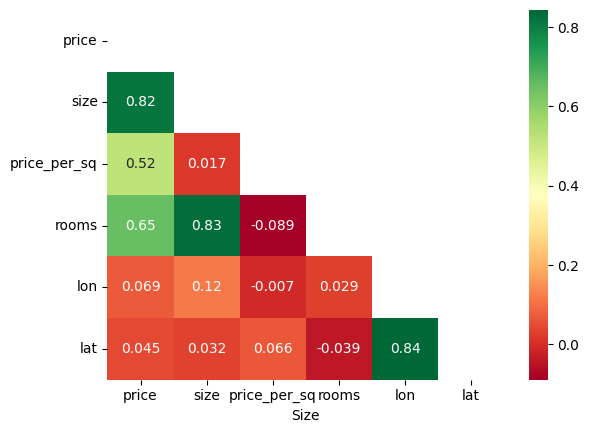

R^2 score is : 0.701


In [38]:
linear_reg = linear_reg_neigbourhood(df_housing, 'Mokotów')

### Same function, but whithout all the plots :

In [35]:
#We want to see the score on each neighbourhood. We will update our function to no display all the plots
def linear_reg_neigbourhood_score(df_housing, neighbourhood):
    
    df_housing_neighbourhood = df_housing[df_housing['neighbourhood'] == neighbourhood].copy()
    
    df_housing_neighbourhood = outliers(df_housing_neighbourhood)
    df_housing_neighbourhood = df_housing_neighbourhood.dropna()
    
    if df_housing_neighbourhood.shape[0] > 2 :
        
        #Inizialization of Linear regression
        model = linear_model.LinearRegression()
        df_housing_neighbourhood.drop(columns = ['housing_type', 'price_per_sq', 'rooms', 'neighbourhood', 'website', 'date', 'lon', 'lat'], inplace = True)

        #X-y split
        X = df_housing_neighbourhood.drop('price', axis=1)
        y = df_housing_neighbourhood['price']
        
        #Results
        result = model.fit(X, y)
        
        return (round(model.score(X, y), 3), result.intercept_, result.coef_)
    
    else :
        return f'Not enough data for {neighbourhood}'

In [36]:
dict_score = {}
for neighbourhood in neighbourhoods:
    dict_score[neighbourhood] = linear_reg_neigbourhood_score(df_housing, neighbourhood)
    if type(dict_score[neighbourhood]) == tuple:
        dict_score[neighbourhood] = linear_reg_neigbourhood_score(df_housing, neighbourhood)[0]
    else:
        dict_score[neighbourhood] = linear_reg_neigbourhood_score(df_housing, neighbourhood)
dict_score

{'Bemowo': 0.515,
 'Białołęka': 0.148,
 'Bielany': 0.66,
 'Mokotów': 0.701,
 'Ochota': 0.752,
 'Praga': 0.614,
 'Rembertów': 'Not enough data for Rembertów',
 'Targówek': 0.85,
 'Ursus': 'Not enough data for Ursus',
 'Ursynów': 0.671,
 'Wawer': 0.336,
 'Wesoła': 0.25,
 'Wilanów': 0.809,
 'Wola': 0.79,
 'Włochy': 0.942,
 'Śródmieście': 0.661,
 'Żoliborz': 0.815}

We are not having great result for each neighboorhoud

## **Multiple linear regression**

In [124]:
df_copy = df_housing.copy()

,size,rooms_2,rooms_3,rooms_4,rooms_5,rooms_6,rooms_7,rooms_8,neighbourhood_Białołęka,neighbourhood_Bielany,...,neighbourhood_Targówek,neighbourhood_Ursus,neighbourhood_Ursynów,neighbourhood_Wawer,neighbourhood_Wesoła,neighbourhood_Wilanów,neighbourhood_Wola,neighbourhood_Włochy,neighbourhood_Śródmieście,neighbourhood_Żoliborz
0,-0.108229,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.341736,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.108229,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.588854,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.156719,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


[1364424.19929407 1188160.89142115 9859462.75776534 1037300.98323051
 1495772.42762837 1617820.01310907 1288034.90201075 1024728.71156232
 1157512.79724587  622467.07134299 1024728.71156232 1139221.27875922
 3946567.33246739  844787.45722243  853004.11545173  660658.2603537
  187525.71806321 1055380.00845434  659014.82235209  810766.37043235
  961982.96861692 3050149.37715542  437362.36258586 2526205.53240039
 2122129.16695894 2159373.7123861   798872.82215227  493718.3580545
 2182938.04289599 1364424.19929407 1600951.04837769 1325504.77402571
  715369.41561958  417965.8622311  2675870.94312805 1036944.29323658
  289500.30522183  627683.62697173 1655275.21188757 1158455.83215915
  494722.83132947 1309447.96357271  656740.61509865  627683.62697173
 1392615.99591178 1617820.01310907 1221903.05317037 1093613.56148772
 1405090.48776593 1245124.42800525  777715.83920588 1344042.79417781
  945998.31061414 1444317.81545645] 316605529669.16754 0.6703384434842696


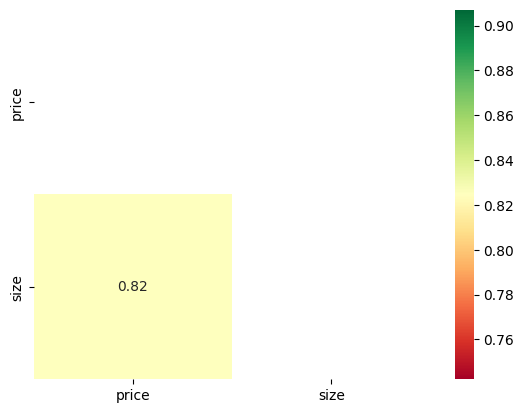

In [161]:
cols = ['price', 'size', 'rooms', 'neighbourhood']
df_copy = df_copy[cols]
df_copy['rooms'] = df_copy['rooms'].apply(lambda x : str(x))

#Use plotly to create a figure with n rows and 2 columns
fig = make_subplots(rows=df_copy.shape[1], cols=2)

#Create a loop for histogram plots
for i, col in enumerate(df_copy.columns):
    fig.add_trace(go.Histogram(x=df_copy[col], name=col), row=i+1, col=1)

#Create a loop for box plots
for i, col in enumerate(df_copy.columns):
    fig.add_trace(go.Box(x=df_copy[col], name=col), row=i+1, col=2)

#Adjust the height, width, and title of the layout
fig.update_layout(height=200 * df_copy.shape[1], width=1000, title_text="Target vs Feature distributions")
fig.show()

housing_corr = df_copy.corr(numeric_only = True)
housing_corr.style.background_gradient(cmap='RdYlGn').format('{:,.2f}')

mask = np.zeros_like(housing_corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(housing_corr, mask=mask, annot=True, cmap='RdYlGn')

num = df_copy.select_dtypes(np.number).drop('price', axis=1)
num_scaled = pd.DataFrame(StandardScaler().fit_transform(num), columns=num.columns)

cat = df_copy.select_dtypes(object)
cat_encoded = pd.get_dummies(cat, drop_first=True)

df_copy_processed = pd.concat([num_scaled, cat_encoded], axis=1)
display(df_copy_processed.head())

X = df_copy_processed
y = df_copy['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = linear_model.LinearRegression()
result = model.fit(X_train, y_train)

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(pred, mse, r2)

In [170]:
def predictions_multiple_linear(input_size, rooms, neighbourhood):
    
    inputs = {
    'size': input_size,  
}

    for i in range(2, 9):
        inputs[f'rooms_{i}'] = False
    if rooms > 1 :
        inputs[f'rooms_{rooms}'] = True

    neighbourhoods = pd.read_csv('warsaw_neighbourhood.csv')
    neighbourhoods = list(neighbourhoods['Name Sort data by column'])
    neighbourhoods.remove('Bemowo')
    for neighb in neighbourhoods:
        inputs[f'neighbourhood_{neighb}'] = False
    if neighbourhood != 'Bemowo':
        inputs[f'neighbourhood_{neighbourhood}'] = True

    # Create a DataFrame from user input
    df_inputs = pd.DataFrame([inputs])

    # Use the trained model to make predictions
    predicted_price = model.predict(df_inputs)

    # Print the predicted price
    return(f"Predicted Price: {round(predicted_price[0], 2)}zl")

In [172]:
predictions_multiple_linear(100, 2, 'Wola')

'Predicted Price: 114286822.38zl'

Need more time to investigate here and understand the results

# **User interfaces in tkinter for simple linear regression**

## Price indicator

In [15]:
#Tkinter interface 1

#Function for the button
def button():
    selected_neighbourhood = neighbourhood.get()
    input1_value = input1.get()
    input2_value = input2.get()
    output = price_analysis_app(selected_neighbourhood, int(input1_value), int(input2_value))
    result_label.config(text=output)
    
#Function that will give the result
def price_analysis_app (neighbourhood_input, price_input, size_input):
    linear_reg = linear_reg_neigbourhood_score(df_housing, neighbourhood_input) #Mokotów
    score, intercept, coef = linear_reg[0], linear_reg[1], linear_reg[2]
    prediction_price = intercept + coef * size_input
    
    #As running the master data set and this function several time, I have noticed a few thing that we need to handle for the user.
    #The score change everytime we add data, so it might be that somethime the score is too low for good prediction
    #Sometimes we do not have enought data to run the linear regression

    if type(score) == np.float64:
        if score > 0.75 :
            if price_input < prediction_price[0]:
                return('This flat is below price market.')
            else:
                return('This flat is above price market.')
        
        elif score < 0.75 and score > 0.5 : 
            if price_input < prediction_price[0]:
                return('This flat might be below price market.')
            else:
                return('This flat might be above price market.')
        else :
            return ('We do not have enought data or good enought data to conclude on this district')
    else :
        return ('We do not have enought data or good enought data to conclude on this district')
    
#Tkinter window
app = tk.Tk()
app.title("Housing price indicator")

#Dropdown menu with Warsaw neighnourhoods
neighbourhoods = pd.read_csv('warsaw_neighbourhood.csv')
neighbourhoods = list(neighbourhoods['Name Sort data by column'])

neighbourhood_label = tk.Label(app, text="Select a neighbourhood:")
neighbourhood_label.pack()

neighbourhood = tk.StringVar(value=neighbourhoods[0])
neighbourhood_dropdown = ttk.Combobox(app, textvariable=neighbourhood, values=neighbourhoods)
neighbourhood_dropdown.pack()

#Price input
input1_label = tk.Label(app, text="Price witnessed :")
input1_label.pack()
input1 = tk.Entry(app)
input1.pack()

#Size input
input2_label = tk.Label(app, text="Size witnessed:")
input2_label.pack()
input2 = tk.Entry(app)
input2.pack()

#Button
button = tk.Button(app, text="Send for checking", command=button)
button.pack()

#Result
result_label = tk.Label(app, text='Waiting for inputs')
result_label.pack()

app.mainloop()

## Price estimator

In [11]:
#Tkinter interface 2

#Function for the button
def button():
    selected_neighbourhood = neighbourhood.get()
    input1_value = input1.get()
    output = market_price(selected_neighbourhood, int(input1_value))
    result_label.config(text=output)

#Function that will give the result
def market_price (neighbourhood_input, size_input):
    linear_reg = linear_reg_neigbourhood_score(df_housing, neighbourhood_input)
    intercept, coef = linear_reg[1], linear_reg[2]
    prediction_price = intercept + coef * size_input
    prediction_price = round(prediction_price[0])
    return str(prediction_price) + 'zl'
    
#Tkinter window
app = tk.Tk()
app.title("Housing price estimator")

#Dropdown menu with Warsaw neighnourhoods
neighbourhoods = pd.read_csv('warsaw_neighbourhood.csv')
neighbourhoods = list(neighbourhoods['Name Sort data by column'])

neighbourhood_label = tk.Label(app, text="Neighbourhood you live:")
neighbourhood_label.pack()

neighbourhood = tk.StringVar(value=neighbourhoods[0])
neighbourhood_dropdown = ttk.Combobox(app, textvariable=neighbourhood, values=neighbourhoods)
neighbourhood_dropdown.pack()

#Size input
input1_label = tk.Label(app, text="Size of your flat:")
input1_label.pack()
input1 = tk.Entry(app)
input1.pack()

#Button
button = tk.Button(app, text="Send for checking", command=button)
button.pack()

#Result
result_label = tk.Label(app, text='Waiting for inputs')
result_label.pack()

app.mainloop()